# CIR Model to simulate changes in Interest Rates and Liability Hedging
The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates: 
$$dr_t = a(b-r_t)dt+\sigma \sqrt{r_t}dW_t$$

Mean reverting model.
* a: speed of reversion
* b: Long Term Mean

## Short Rate vs Annualized 


In [5]:
1 +1*0.5+ (1 +1*0.5)*0.5

2.25

In [33]:
import numpy as np 
import pandas as pd
import edhec_risk_kit as erk 
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annualized to a short rate 
    """
    return np.log1p(r)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ann_to_inst(1)

0.6931471805599453

In [6]:
inst_to_ann(0.6931471805599453)

1.0

In [9]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, 
        steps_per_year=12, r_0 =None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps= int(n_years*steps_per_year)
    shock=np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    for step in range(1, num_steps):
        r_t=rates[step-1]
        dr_t = a*(b-r_t)*dt + sigma * np.sqrt(r_t) * shock[step]
        
        rates[step] = abs(r_t+dr_t)
    
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<AxesSubplot:>

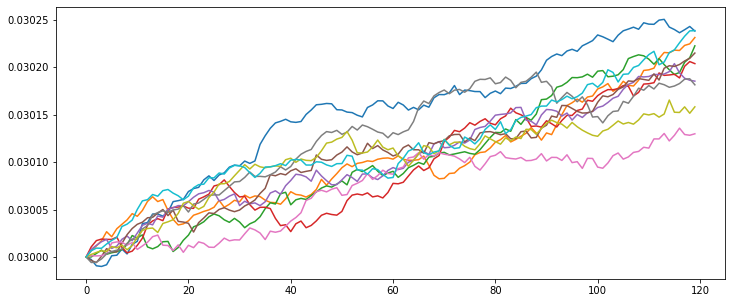

In [14]:
cir(n_scenarios=10, sigma=0.0001).plot(figsize=(12,5) ,legend = False)

In [17]:
import ipywidgets as widgets 
from IPython.display import display
def show_cir(r_0 = 0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma= sigma, n_scenarios=n_scenarios).plot(legend=False, 
                                                                      figsize=(12,5))


controls = widgets.interactive(show_cir, 
                              r_0 = (0, .15, .01),
                               a=(0, 1, .1),
                               b=(0, .15, .01),
                               sigma=(0, .1, .01),
                               n_scenarios=(1, 100)
                              )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t, T)= A(t, T)e^{-B(t, T)r_t}$$

where

$$A(t,T) = \left( \frac{2he^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}\right)^{2ab/\sigma^2}$$

and
$$B(t,T) = \frac{2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}$$

and
$$h = \sqrt{a^2+2\sigma^2}$$
and
$$\tau = T -t$$

In [22]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, 
        steps_per_year=12, r_0 =None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps= int(n_years*steps_per_year)
    shock=np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    for step in range(1, num_steps):
        r_t=rates[step-1]
        dr_t = a*(b-r_t)*dt + sigma * np.sqrt(r_t) * shock[step]
        
        rates[step] = abs(r_t+dr_t)
        
    ## For Price Generation
    h = math.sqrt(a**2+sigma**2)
    prices = np.empty_like(shock)
    ####
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(a+h)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1)/(2*h+(h+a)*(math.exp(h*ttm)-1)))
        _P = _A*np.exp(-_B*r)
        return _P
    
    prices[0] = price(n_years, r_0)
    ###
    
    for step in range(1, num_steps):
        r_t=rates[step-1]
        dr_t = a*(b-r_t)*dt + sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t+dr_t)
        # generate prices at time t as well...
        prices[step] = price(n_years - step*dt, rates[step])
    
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ## for prices 
    prices = pd.DataFrame(data=prices, index=range(num_steps))
        
    return rates, prices

In [23]:
import ipywidgets as widgets 
from IPython.display import display
def show_cir_prices(r_0 = 0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma= sigma, n_scenarios=n_scenarios)[1].plot(legend=False, 
                                                                      figsize=(12,5))


controls = widgets.interactive(show_cir_prices, 
                              r_0 = (0, .15, .01),
                               a=(0, 1, .1),
                               b=(0, .15, .01),
                               sigma=(0, .1, .01),
                               n_scenarios=(1, 100)
                              )
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [46]:
a_0 = .75
rates, bonds_prices = cir(n_years=10, r_0 = 0.03, b=0.03, n_scenarios=10)
liabilities = bonds_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds=float(n_bonds)*bonds_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:>

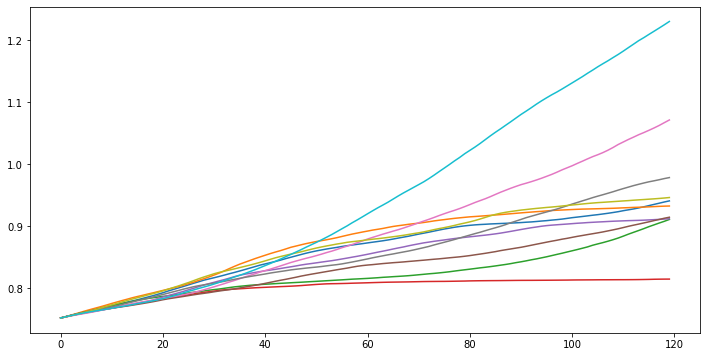

In [47]:
av_cash.plot(legend = False, figsize =(12,6))

<AxesSubplot:>

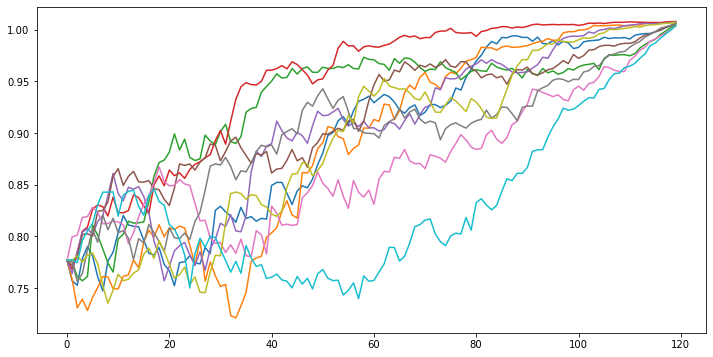

In [54]:
av_zc_bonds.plot(legend = False, figsize =(12,6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash'}>

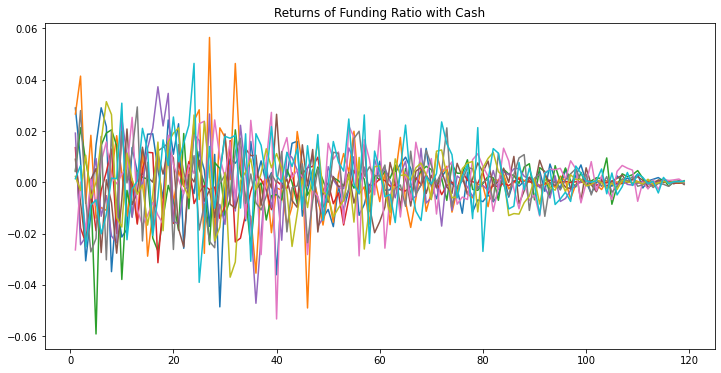

In [55]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash', 
                                       legend=False, figsize=(12,6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with ZeroCuponBonds'}>

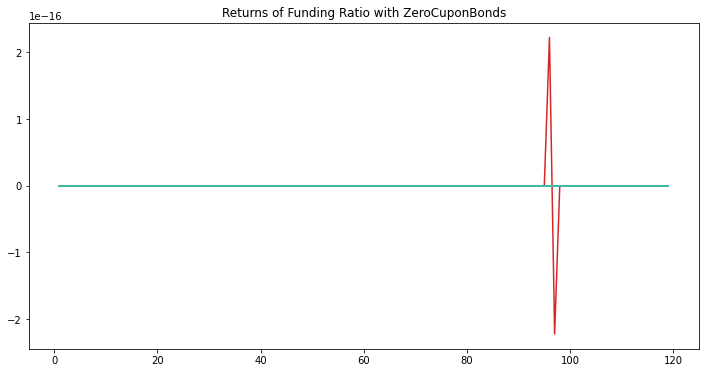

In [58]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZeroCuponBonds', 
                                       legend=False, figsize=(12,6))

In [59]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0 = 0.03, b = 0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = float(a_0/zc_0)
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:ylabel='Frequency'>

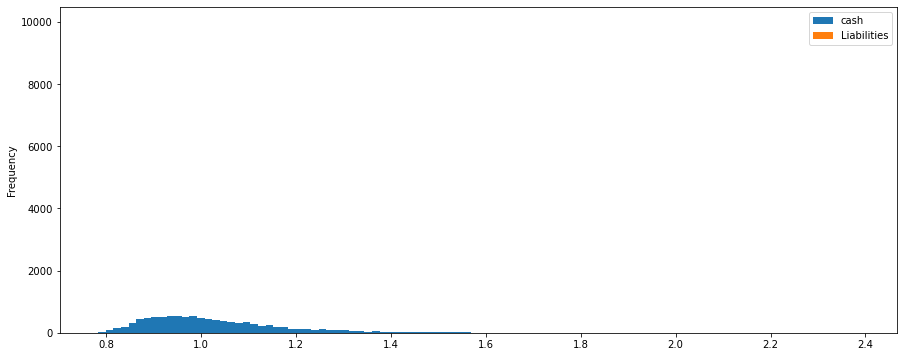

In [68]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="cash", figsize=(15,6), bins =100, legend=True)
tfr_zc_bonds.plot.hist(ax = ax, label="Liabilities", figsize=(15,6), legend=True)

<AxesSubplot:ylabel='Frequency'>

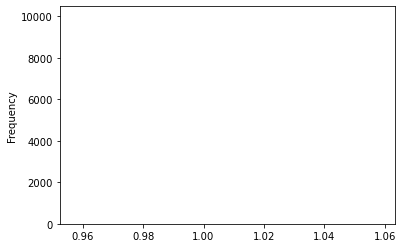

In [66]:
tfr_zc_bonds.plot.hist()

In [67]:
tfr_zc_bonds

0       1.007937
1       1.007937
2       1.007937
3       1.007937
4       1.007937
          ...   
9995    1.007937
9996    1.007937
9997    1.007937
9998    1.007937
9999    1.007937
Name: 119, Length: 10000, dtype: float64

In [69]:
liabilities

0         1         2         3         4         5         6     \
0    0.770588  0.770588  0.770588  0.770588  0.770588  0.770588  0.770588   
1    0.756999  0.761119  0.781900  0.760194  0.776345  0.760262  0.776380   
2    0.751761  0.749852  0.767620  0.772268  0.792547  0.737349  0.774836   
3    0.748803  0.767781  0.764651  0.760376  0.804218  0.749291  0.768345   
4    0.762169  0.766858  0.765013  0.790949  0.819084  0.733111  0.793167   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.994869  0.990803  0.998100  0.983999  0.993981  0.965239  0.993074   
116  0.995667  0.993083  0.998705  0.986917  0.995416  0.969836  0.995450   
117  0.997040  0.995119  0.998798  0.989371  0.996908  0.976274  0.996331   
118  0.998199  0.996974  0.999181  0.992889  0.997973  0.984076  0.997628   
119  0.999101  0.998600  0.999623  0.996695  0.998774  0.991648  0.999028   

         7         8         9     ...      9990      9991      9992  \
0    0.770588  0.770588  0.770588  ...  0.770588  0.770588  0.770588   
1    0.774558  0.770791  0.785233  ...  0.766103  0.769775  0.771708   
2    0.774947  0.755990  0.791621  ...  0.784711  0.771115  0.770321   
3    0.750715  0.748404  0.797405  ...  0.777764  0.778029  0.780580   
4    0.757546  0.733455  0.824016  ...  0.794243  0.787836  0.790557   
..        ...       ...       ...  ...       ...       ...       ...   
115  0.981026  0.987163  0.989620  ...  0.997093  0.983549  0.990127   
116  0.985617  0.989172  0.992541  ...  0.997224  0.986043  0.993201   
117  0.987683  0.991774  0.994122  ...  0.997650  0.989047  0.994533   
118  0.991525  0.994857  0.996104  ...  0.997980  0.992521  0.996583   
119  0.995656  0.997373  0.998016  ...  0.998757  0.996381  0.998444   

         9993      9994      9995      9996      9997      9998      9999  
0    0.770588  0.770588  0.770588  0.770588  0.770588  0.770588  0.770588  
1    0.763670  0.749548  0.727257  0.760394  0.756250  0.798924  0.789040  
2    0.758182  0.726509  0.731205  0.765758  0.785256  0.784671  0.794300  
3    0.779800  0.733660  0.724237  0.758250  0.789796  0.798226  0.772029  
4    0.795727  0.722812  0.749430  0.765566  0.793902  0.803032  0.760523  
..        ...       ...       ...       ...       ...       ...       ...  
115  0.995366  0.987141  0.979360  0.981662  0.987940  0.995762  0.974638  
116  0.996736  0.989807  0.983187  0.985229  0.991233  0.996315  0.980802  
117  0.997816  0.991533  0.987647  0.988766  0.993111  0.997126  0.985941  
118  0.998496  0.993615  0.991449  0.992781  0.994845  0.998113  0.990723  
119  0.999330  0.996662  0.995797  0.996309  0.997362  0.999111  0.995663  

[120 rows x 10000 columns]